# Linear Regression Exercise
이 연습에서는 경사강하(gradient descent)를 사용하여 간단한 선형 회귀를 구현하고, 이를 예제 문제에 적용합니다. 또한 구현을 확장하여 다수의 변수를 처리하고, 좀 더 어려운 예제에 적용 할 것입니다.

### 단변량 선형회귀
연습의 첫 번째 부분에서는 식품 트럭의 이익을 예측하기 위해 변수 하나를 사용하여 선형 회귀를 구현해야 합니다. 당신이 레스토랑 프랜차이즈의 CEO이고, 새로운 매장을 열 다른 도시를 고려한다고 가정 해보십시오. 체인에는 이미 여러 도시에 트럭이 있으며, 도시의 이익과 인구에 대한 데이터가 있습니다.

먼저 일부 라이브러리를 가져 와서, 데이터를 검사 해 봅시다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os
path = os.getcwd() + '\data\ex1data1.txt'
data = pd.read_csv(path, header=None, names=['Population', 'Profit'])
data.head()

,Population,Profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


In [4]:
data.describe()

,Population,Profit
count,97.000000,97.000000
mean,8.159800,5.839135
std,3.869884,5.510262
min,5.026900,-2.680700
25%,5.707700,1.986900
50%,6.589400,4.562300
75%,8.578100,7.046700
max,22.203000,24.147000


데이터가 어떻게 생겼는 지를 더 잘 이해하기 위해 그려보자.

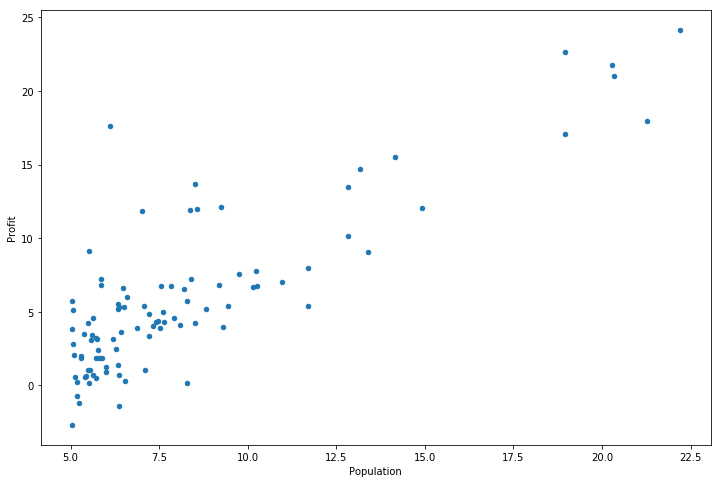

In [5]:
data.plot(kind='scatter', x='Population', y='Profit', figsize=(12,8))

이제 비용 함수를 최소화하기 위해 그래디언트 디센트를 사용하여 선형 회귀를 구현해 보겠습니다. 이 때 선형 회귀 매개 변수 $\theta$ 를 지정한다.

#### 방정식 업데이트
선형회귀의 목적은 비용함수를 최소화 하는 것이다.
$$J(\theta) = { 1 \over 2m}\sum_{i=1}^m (h_\theta ( x^{(i)}) - y^{(i)})^2$$
여기에서 가설 $h(x)$ 는 다음과 같은 선형모델로 주어진다.
$$h_\theta(x) = \mathbf {\theta^T x }= \theta_0 + \theta_1 x_1$$
모델의 매개 변수는 $\theta_j$ 값 이라는 점을 상기하십시오. 비용 $J(\theta)$를 최소화하기 위해 조정할 값입니다. 이를 수행하는 한 가지 방법은 그라디언트 디센트 알고리즘을 사용하는 것입니다. 그라디언트 디센트에서의 각 반복은 다음의 업데이트를 수행합니다.
$$ \theta_j := \theta_j - \alpha {1 \over m } \sum_{i=1}^m (h_\theta ( x^{(i)}) - y^{(i)}) x_j^{(i)} $$
여기에서 모든 j에 대하여 $\theta_j$를 동시에 갱신합니다.

#### 구현
먼저 주어진 솔루션의 비용을 계산하는 함수를 만듭니다 (매개 변수 $\theta$로 특징 지어 짐).

In [7]:
def computeCost(X, y, theta):
    inner = np.power(((X * theta.T) - y), 2)
    return np.sum(inner) / (2 * len(X))

훈련 자료에 1 열을 추가하여, 비용 및 그레디언트를 계산하기 위해 벡터화 된 솔루션을 사용할 수 있도록 하겠습니다.

In [8]:
data.insert(0, 'Ones', 1)

이제 몇몇 변수들을 초기화를 해봅시다.

In [9]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

X (훈련 세트)와 y (목표 변수)가 올바른지 확인해 봅시다.

In [10]:
X.head()

,Ones,Population
0,1,6.1101
1,1,5.5277
2,1,8.5186
3,1,7.0032
4,1,5.8598


In [11]:
y.head()

,Profit
0,17.5920
1,9.1302
2,13.6620
3,11.8540
4,6.8233


비용 함수는 numpy 행렬을 기대하기 때문에, 사용하기 전에 X와 y를 변환해야 합니다. 우리는 또한 $\theta$ 도 초기화해야 합니다.

In [12]:
X = np.matrix(X.values)
y = np.matrix(y.values)
theta = np.matrix(np.array([0,0]))

$\theta$는 다음과 같습니다.

In [13]:
theta

matrix([[0, 0]])

행렬의 모양을 간단히 살펴 보겠습니다.

In [14]:
X.shape, theta.shape, y.shape

((97, 2), (1, 2), (97, 1))

이제 우리의 초기 솔루션에 대한 비용을 계산해 봅시다 (0 값의 $\theta$에 대한).

In [15]:
computeCost(X, y, theta)


32.072733877455676

여태까지는 그런대로 잘됐다. 이제 위에 정의된 업데이트 규칙을 사용하여, 매개 변수 $\theta$에 그라디언트 디센트를 수행하는 함수를 정의해야 합니다.

In [16]:
def gradientDescent(X, y, theta, alpha, iters):
    temp = np.matrix(np.zeros(theta.shape))
    parameters = int(theta.ravel().shape[1])
    cost = np.zeros(iters)
    
    for i in range(iters):
        error = (X * theta.T) - y
        
        for j in range(parameters):
            term = np.multiply(error, X[:,j])
            temp[0,j] = theta[0,j] - ((alpha / len(X)) * np.sum(term))
            
        theta = temp
        cost[i] = computeCost(X, y, theta)
        
    return theta, cost

몇 가지 추가 변수 (학습 속도 $\alpha$ 및 반복 수행 횟수)를 초기화하십시오.

In [17]:
alpha = 0.01
iters = 1000

이제 경사하강 알고리즘을 실행하여, 우리의 매개변수인 $\theta$를 훈련 세트에 맞춥니 다.

In [18]:
g, cost = gradientDescent(X, y, theta, alpha, iters)
g

matrix([[-3.24140214,  1.1272942 ]])

마지막으로 우리는 적합 매개 변수를 사용하여 훈련된 모델의 비용(오차)을 계산할 수 있습니다.

In [19]:
computeCost(X, y, g)

4.5159555030789118

이제 선형 모델을 데이터와 함께 플롯하여 얼마나 잘 맞는지 눈으로 확인해 보겠습니다.

Text(0.5,1,'Predicted Profit vs. Population Size')

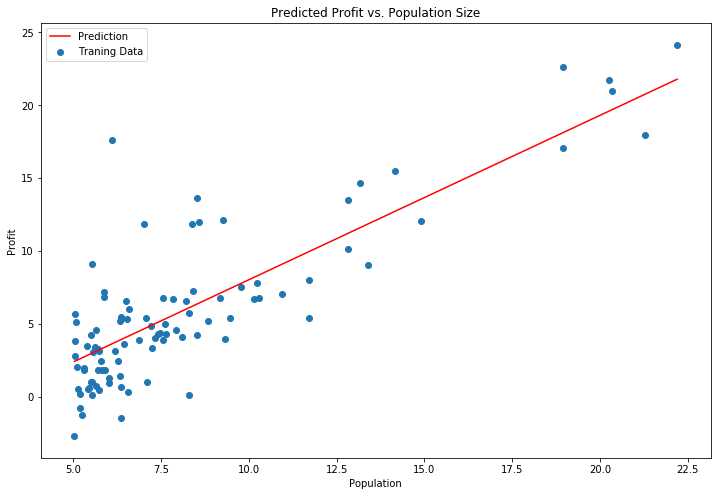

In [20]:
x = np.linspace(data.Population.min(), data.Population.max(), 100)
f = g[0, 0] + (g[0, 1] * x)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x, f, 'r', label='Prediction')
ax.scatter(data.Population, data.Profit, label='Traning Data')
ax.legend(loc=2)
ax.set_xlabel('Population')
ax.set_ylabel('Profit')
ax.set_title('Predicted Profit vs. Population Size')

꽤 좋아 보인다! 경사하강 함수는 각 학습 반복에서 비용이 든 벡터를 출력하기 때문에, 우리는 또한 그것을 플로팅 할 수 있습니다. 비용은 항상 감소합니다. 이는 볼록 최적화(convex optimization) 문제의 예입니다.

Text(0.5,1,'Error vs. Training Epoch')

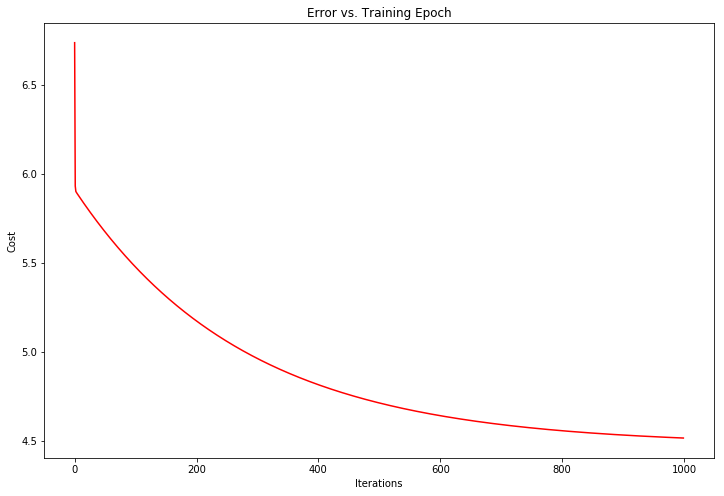

In [21]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(iters), cost, 'r')
ax.set_xlabel('Iterations')
ax.set_ylabel('Cost')
ax.set_title('Error vs. Training Epoch')

## 다변량 선형회귀
연습 1에는 또한 2 개의 변수(주택 크기와 침실 수)와 목표(주택 가격)가 포함 된 주택 가격 데이터 세트가 포함되었습니다. 데이터 세트를 분석하기 위해 이미 적용한 기술을 사용합시다.

In [22]:
path = os.getcwd() + '\data\ex1data2.txt'
data2 = pd.read_csv(path, header=None, names=['Size', 'Bedrooms', 'Price'])
data2.head()

,Size,Bedrooms,Price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


이 작업을 위해 특징(feature)을 표준화하는 또 다른 사전처리 단계를 추가합니다. 이것은 pandas 로 아주 쉽습니다.

In [23]:
data2 = (data2 - data2.mean()) / data2.std()
data2.head()

,Size,Bedrooms,Price
0,0.130010,-0.223675,0.475747
1,-0.504190,-0.223675,-0.084074
2,0.502476,-0.223675,0.228626
3,-0.735723,-1.537767,-0.867025
4,1.257476,1.090417,1.595389


이제 파트 1의 사전 처리 단계를 반복하고, 새로운 데이터 세트에 대한 선형회귀 절차를 실행해 봅시다.

In [24]:
# add ones column
data2.insert(0, 'Ones', 1)

# set X (training data) and y (target variable)
cols = data2.shape[1]
X2 = data2.iloc[:,0:cols-1]
y2 = data2.iloc[:,cols-1:cols]

# convert to matrices and initialize theta
X2 = np.matrix(X2.values)
y2 = np.matrix(y2.values)
theta2 = np.matrix(np.array([0,0,0]))

# perform linear regression on the data set
g2, cost2 = gradientDescent(X2, y2, theta2, alpha, iters)

# get the cost (error) of the model
computeCost(X2, y2, g2)

0.13070336960771892

이 과정의 진행 상황을 간략하게 살펴볼 수 있습니다.

Text(0.5,1,'Error vs. Training Epoch')

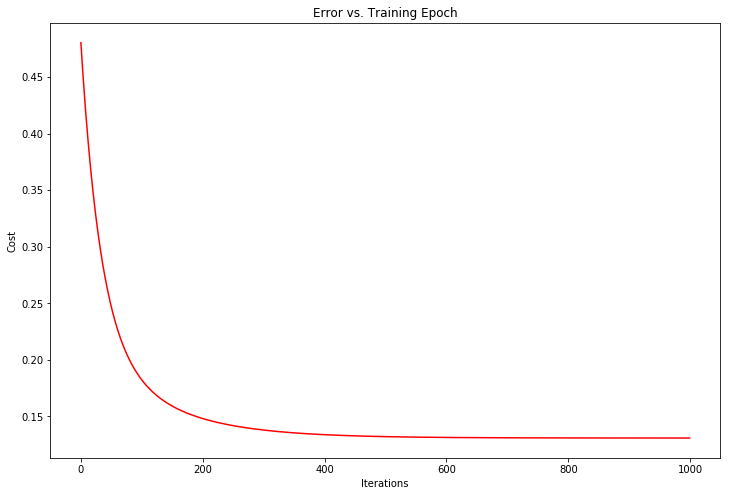

In [26]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(iters), cost2, 'r')
ax.set_xlabel('Iterations')
ax.set_ylabel('Cost')
ax.set_title('Error vs. Training Epoch')

이러한 알고리즘을 처음부터 구현하는 대신 scikit-learn의 선형회귀 함수를 사용할 수도 있습니다. 파트 1의 데이터에 scikit-learn의 선형 회귀 알고리즘을 적용하고 그 결과를 확인해 봅시다.

In [27]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

scikit-learn 모델의 예측은 다음과 같습니다.

Text(0.5,1,'Predicted Profit vs. Population Size')

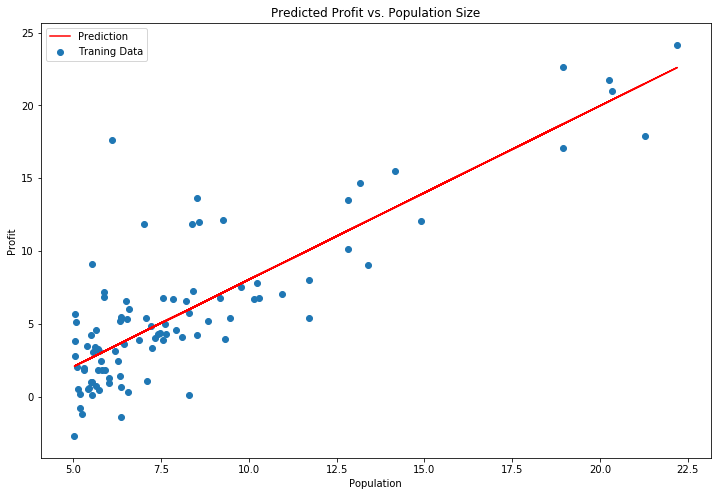

In [28]:
x = np.array(X[:, 1].A1)
f = model.predict(X).flatten()

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x, f, 'r', label='Prediction')
ax.scatter(data.Population, data.Profit, label='Traning Data')
ax.legend(loc=2)
ax.set_xlabel('Population')
ax.set_ylabel('Profit')
ax.set_title('Predicted Profit vs. Population Size')